# Assignment 3: Data Visualisation

Gruppe Dangerous Memory: Jake, Christian, Alexander


## Tasks

**1. Create a plot with the help of Basemap, on which you plot sales records for 2015 which are not farther away than 50km from Copenhagen city center (lat: 55.676111, lon: 12.568333)**


In [2]:
# import 
import zipfile
import pandas as pd
import os.path
import datetime
from tqdm import tqdm
#os.environ["PROJ_LIB"] = "C:\\Users\\awha\\Anaconda3\\Library\\share" # might be needed in windows10
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import folium

Using the dataset form the [previous assignment](https://github.com/Business-Intelligence-Dangerous-Memory/Assignment_2) (containing lan, lot and sales dates as proper datetime objects), unzipped from osm_export.zip to osm_export.csv (if not already extracted):

In [3]:
if not os.path.isfile("osm_export.csv"):
    with zipfile.ZipFile("osm_export.zip", 'r') as zip_ref:
        zip_ref.extractall()

Import the extracted .csv file as a pandas dataframe as df_data:  

In [4]:
df_data = pd.read_csv('osm_export.csv')

Using a [mask](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mask.html) to specify sales records from 2015:

In [5]:
start_2015 = datetime.datetime(2015, 1, 1)
end_2015 = datetime.datetime(2015, 12, 31)
mask = (pd.to_datetime(df_data['sell_date']) > start_2015) & (pd.to_datetime(df_data['sell_date']) <= end_2015)
df_data_2015 = df_data.loc[mask]

Using the following function to compute the [Haversine Distance](https://en.wikipedia.org/wiki/Haversine_formula) from the location of each location in the dataset to the [Copenhagen city center](https://www.latlong.net/place/copenhagen-denmark-4775.html):

In [6]:
import math
def haversine_distance(origin, destination):

    lat_orig, lon_orig = origin
    lat_dest, lon_dest = destination
    radius = 6371

    dlat = math.radians(lat_dest-lat_orig)
    dlon = math.radians(lon_dest-lon_orig)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat_orig)) 
        * math.cos(math.radians(lat_dest)) * math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [7]:
#Copenhagen city center (lat=55.676098, lon=12.568337)
tqdm.pandas(desc="Creating haversine distance to Copenhagen city center")
df_not_nan = df_data.dropna().copy()
list_df = df_not_nan.progress_apply(lambda y : haversine_distance(tuple([55.676098,12.568337]), tuple([y['lat'], y['lon']])), axis=1)

Creating haversine distance to Copenhagen city center: 100%|██████████| 1280975/1280975 [00:53<00:00, 24158.86it/s]


Add the list of haversine distance to Copenhagen city center to the dataframe as a new column:

In [8]:
df_not_nan['hav_dis_cph_50'] = list_df

Create a new dataframe containing locations where the haversine is <= 50km from Copenhagen city center:

In [9]:
df_50_km = df_not_nan[(df_not_nan['hav_dis_cph_50'] <= 50)].copy()

Plot this data using Basemap: 

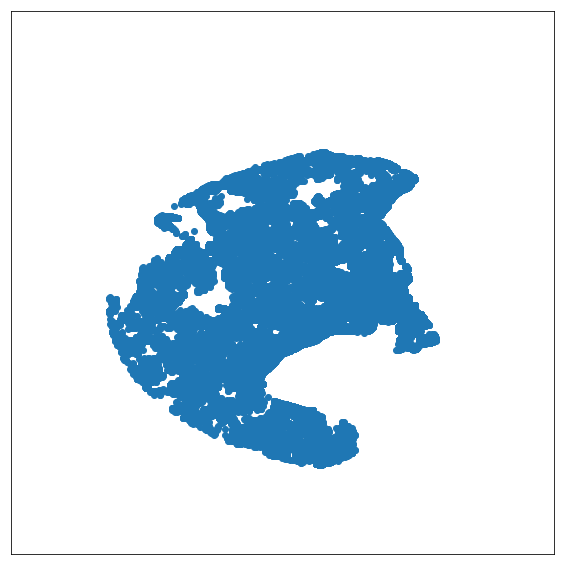

In [113]:
fig = plt.figure(figsize = (10,10))

map = Basemap(
    lat_0=55.676098, 
    lon_0= 12.568337, 
    llcrnrlon=11.5, 
    llcrnrlat=55,
    urcrnrlon=13, 
    urcrnrlat=56.5)

x, y = map(df_50_km['lon'].tolist(), df_50_km['lat'].tolist())
map.scatter(x, y)
plt.show()

**2. Use folium to plot the locations of the 1992 housing sales for the city centers of Copenhagen (zip code 1000-1499), Odense (zip code 5000), Aarhus (zip code 8000), and Aalborg (zip code 9000), see Assignment 2 onto a map.**

Load dataset from csv files, clean NaN values, define folium map start area & zoom level over Denmark, combine a list of the dataframes & concatonate them into 1 dataframe.

for each location in the dataframe, add a marker to the folium map by its lan & lon values, and add address + zip_code as popup marker value.

In [11]:
df_cph = pd.read_csv('year-1992_zip-1050-1499.csv')
df_odense = pd.read_csv('year-1992_zip-5000.csv')
df_aarhus = pd.read_csv('year-1992_zip-8000.csv')
df_aalborg = pd.read_csv('year-1992_zip-9000.csv')

df_cph = df_cph.dropna()
df_odense = df_odense.dropna()
df_aarhus = df_aarhus.dropna()
df_aalborg = df_aalborg.dropna()


m = folium.Map([56,11], zoom_start=7)

all_list = [df_cph, df_odense, df_aarhus, df_aalborg]
df_all = pd.concat(all_list)
for index, row in df_all.iterrows():
    folium.Marker(location=[row['lat'], row['lon']], popup=row['address'] + " " + row['zip_code']).add_to(m)

m

**3. Create a 2D plot, which compares prices per square meter (on the x-axis) and distance to Nørreport st. (y-axis) for all housing on Sjæland for the year 2005 and where the zip code is lower than 3000 and the price per square meter is lower than 80000Dkk. Describe in words what you can read out of the plot. Formulate a hypothesis on how the values on the two axis might be related.**

Define a mask for 2005 and filter the data into df_data_2005 dataframe.

Define a mask for < 80k square meter price and filter the data into df_data_2005_80k dataframe.

Add a new column to the dataframe, containing the zip code only.

Define a mask for < 3k zip code and filter the data into df_data_2005_80k_3k dataframe.

In [106]:
start_2005 = datetime.datetime(2005, 1, 1)
end_2005 = datetime.datetime(2005, 12, 31)
mask_2005 = (pd.to_datetime(df_data['sell_date']) > start_2005) & (pd.to_datetime(df_data['sell_date']) <= end_2005)
df_data_2005 = df_not_nan.loc[mask_2005].copy()

mask_80k = (df_data['price_per_sq_m'] < 80000)
df_data_2005_80k = df_data_2005.loc[mask_80k].copy()

zip_3k = df_data_2005_80k['zip_code'].str.split(" ", n = 1, expand = True) 
df_data_2005_80k['zip'] = zip_3k[0]

mask_3k = (df_data_2005_80k['zip'].astype(int) < 3000)
df_data_2005_80k_3k = df_data_2005_80k.loc[mask_3k].copy()

Using Haversine Distance function from the location of each location in the dataset to [Nørreport station](https://latitude.to/articles-by-country/dk/denmark/39321/norreport-station) to create a list and add it to the dataframe:

In [107]:
#lat/lon nørreport st: 55.6833306 12.569664388
tqdm.pandas(desc="Creating haversine distance to Nørreport st.")
list_hav_norreport = df_data_2005_80k_3k.progress_apply(lambda y : haversine_distance(tuple([55.6833306,12.569664388]), tuple([y['lat'], y['lon']])), axis=1)
df_data_2005_80k_3k['hav_dis_norreport'] = list_hav_norreport

Creating haversine distance to Nørreport st.: 100%|██████████| 13049/13049 [00:00<00:00, 23768.47it/s]


Plot the data: Price per square meter (on the x-axis) and distance to Nørreport st. (y-axis):

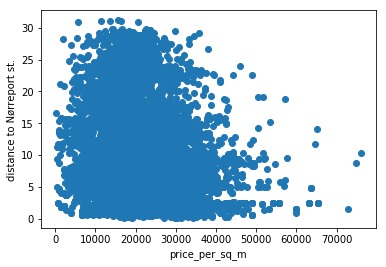

In [112]:
plt.scatter(df_data_2005_80k_3k['price_per_sq_m'],df_data_2005_80k_3k['hav_dis_norreport'])
plt.ylabel('distance to Nørreport st.')
plt.xlabel('price_per_sq_m')
plt.show()

The plot above might indicate that the price per square meter of a location is related to the distance to Nørreport st.; 
**The closer the distance, the higher the price.** 

**4. Create a histogram (bar plot), which visualizes the frequency of house trades per zip code area corresponding to the entire dataset of housing sale records.**

**5. Create a cumulatve histogram, which visualizes the frequency of house trades per zip code area corresponding to the entire dataset of housing sale records and the vertical bars are colored to the frequency of rooms per sales record. That is, a plot similar to the following, where single rooms are in the bottom and two room frequencies on top, etc. See, http://matplotlib.org/1.3.0/examples/pylab\_examples/histogram\_demo\_extended.html for example.**


**6. Now, you create a 3D histogram, in which you plot the frequency of house trades per zip code area as a 'layer' for every in the dataset, see http://matplotlib.org/examples/mplot3d/index.html for an example.**

**7. Freestyle Create a plot, which visualizes a fact hidden in the housing sales data, which you want to highlight to business people.**